# Proyecto 04 - Sistemas de Recomendación versión II

## Dataset: STEAM

<font size="3">En el trabajo número III trabajamos con sistemas de recomendación y realizamos predicciones mediante la librería  "surprice" el método de filtros colaborativos SVD. y encontramso que el modelo tenía una buena perfomance cuando entrenábamos con jugadores que hayan jugado más de 50 veces.  Cuando entrenábamos el modelo con jugadores que habían jugado menos de 50 veces el resultado no era bueno. Justamente porque estábamos entrenando el modelo para jugadores con pocas instancias de juego. 

## Consigna

<font size="3">Diseñaremos un algoritmo que nos permita recomendar a usuarios que hayan jugado pocas veces. Basándonos en el concepto de "similaridad de juegos". Es decir compararemos los juegos ya jugados por el jugador en base a algun atributo asociado al genero o al tipo de juego y buscaremos en la lista de juegos disponibles aquellos que sean similares y propondremos los diez juegos mas parecidos. Para hacer esto trabajaremos con el indice de Jaccard. Dicho indice permite cuantificar la similitud entre dos vectores.

<font size="4">Importamos el dataset de juegos </font>


In [240]:
import gzip
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt


def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [120]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [248]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


<font size="5"> Hipótesis </font>

<font size="3">Una manera de comparar similitud entre juegos es a través del atributo <strong>tags</strong>. Agregaremos al dataframe un atributo nuevo por cada valor en  "tags" y luego aplicaremos técnicas de encoding colocando un 0 o un 1 en cada relación "juego-tag" indicando si al juego le corresponde esa categoría o no. Utilizaremos este dataframe para realizar la recomendación en base al coeficiente de Jaccard. Suponiendo que cuantos mas juegos utilicemos para calcular la recomendacion mejor será la recomendación.

## Preparación del dataset

<font size=3> a) Generamos un dataset con la lista de nombre de juegos, pues para calcular el coeficiente de Jaccard debo dejar el dataframe solo con números. Lo usremos al final cuando armemos la tabla de recomendaciones

In [4]:
nombre_juegos = data_games[['id','app_name']].copy()

<font size=3> b) Dado que la columna "tags" en el dataframe es del tipo "array" , debemos convertirla a texto para poder generar las nuevas columnas del dataframe a través del método "get_dummies". Con lo cual generamos un nuevo dataframe con esas columnas convertidas 

In [5]:
test=data_games[['id','tags']].copy()

In [6]:
test.dropna(inplace = True)

In [7]:
test['tags_str'] = [','.join(map(str, l)) for l in test['tags']]

In [8]:
test

,id,tags,tags_str
0,761140,"[Strategy, Action, Indie, Casual, Simulation]","Strategy,Action,Indie,Casual,Simulation"
1,643980,"[Free to Play, Strategy, Indie, RPG, Card Game...","Free to Play,Strategy,Indie,RPG,Card Game,Trad..."
2,670290,"[Free to Play, Simulation, Sports, Casual, Ind...","Free to Play,Simulation,Sports,Casual,Indie,Mu..."
3,767400,"[Action, Adventure, Casual]","Action,Adventure,Casual"
4,773570,"[Action, Indie, Casual, Sports]","Action,Indie,Casual,Sports"
...,...,...,...
32130,773640,"[Strategy, Indie, Casual, Simulation]","Strategy,Indie,Casual,Simulation"
32131,733530,"[Strategy, Indie, Casual]","Strategy,Indie,Casual"
32132,610660,"[Indie, Simulation, Racing]","Indie,Simulation,Racing"
32133,658870,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","Indie,Casual,Puzzle,Singleplayer,Atmospheric,R..."


<font size=3>c) Aplicamos el método get_dummies para convertir las variables categóricas en features del dataset. Genero así el dataset "categorias"

In [9]:
categorias=pd.Series(test['tags_str']).str.get_dummies(sep=',')

In [10]:
categorias.head(10)

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font size=3> d) Unimos el dataset con el encooding de categorías y el dataset "test" y genero el dataset "resultado"

In [249]:
#Uno la el encooding de categorias en el dataframe resultados
resultado=test.join(categorias)

In [250]:
# Elimino las columnas que no van
resultado.drop(columns=['tags','tags_str'], inplace=True)

In [251]:
resultado.head(2)

,id,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,761140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<strong>Listo!</strong> el dataset está listo para aplicarle el cálculo del índice de Jaccard

<font size="3">Suponiendo que queremos proponer diez juegos a un jugador que jugó una sola vez un juego colocamos el ID del juego que jugó para poder predecir la recomendación

In [252]:
data_reviews=pd.read_csv('data_reviews.csv')
data_reviews.head()

,username,product_id,user_id,rating
0,Chaos Syren,725280,1,1
1,Ariman1,328100,2,2
2,Ariman1,521230,2,1
3,Ariman1,493980,2,1
4,freakfantom,725280,3,1


 <font size="3">Buscamos dentro del dataset de "data_reviews" generado en el trabajo 3 la lista de usaurios que jugaron menos de 5 veces.

In [253]:
salida=data_reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
salida[salida.product_id<5]

,product_id,rating
user_id,,
1,1,1
2,3,3
3,1,1
5,1,1
6,1,1
...,...,...
540337,1,1
540338,1,1
540339,1,1


<font size="3">Definimos una función llamada **recomienda** la cual es la encargada de hacer la recomendación en base a:

+ <font size="3">***id_jugador:*** En base a este ID busca en el dataset_datareview los juegos que el jugador jugó para buscar similitudes.
+ <font size="3">***limite*** Es un parámetro que acota el subjonjunto de juegos sobre el que vamos a recomendar. es una forma de achicar el universo de 32.000 juegos dado que si corremos la evaluación para todos los juegos el proceso tardaría mucho. Y tampoco podemos de algún modo "pre-evaluar" los juegos pues generaríamos una dataset de 32.000x32.000 instancias. Lo interesante del límite es que aplicamos un método de pandas denomindado ***samples*** el cual nos permite sacar una muestra al azar. Esto asegura que si corremos varias veces no tome siempre el mismo subconjunto de juegos para generar la lista de predicciones. 
+ <font size="3">Luego por cada juego que haya jugado el jugador el algoritmo compara la cercanía contra todos los juegos disponibles calculando el coeficiente de ***jaccard*** y propone los diez primeros.
+ <font size="3">Adicionalmente se calcula la media del coeficiente de Jaccard de esa recomendación y se la toma como un valor de métrica.
+ <font size="3">En base a el valor de la media del coeficiente de Jaccard califica el proeso de evaluación en Excelente, Muy BUeno, Bueno o Mediocre.
+ <font size="3">La función tiene un parámetro salida donde la salida ***1*** nos va a mostrar el resultado en un mensaje de texto y la salida ***2*** nos devolverá la media del índice de Jaccard. Esto lo usamos para reutilizar la función y poder graficar.
    

In [244]:
def recomienda(id_jugador, limite, salida):
   
    # Tomo el subconjunto de juegos que usare para comparar y proponer
    
    setEvaluacion=resultado.sample(limite).copy()

    lista_juegos=data_reviews['product_id'][data_reviews.user_id==id_jugador].values
    
    #Defino un dataframe de resultados
  
    base={'id_producto':[0],'jaccard':[0]}
    
    recomendacion = pd.DataFrame(data=base)

    # Tomo la lista de juegos sobre los cuales vamos a evaluar
    
    product_list=setEvaluacion['id'].values

    i=0
    
    cuentaJuegosEvaluados=0

    for id_producto in lista_juegos: 
        
        i=0
        
        cuentaJuegosEvaluados=cuentaJuegosEvaluados+1
        
        for valor in product_list:
            
            y_pred=resultado[resultado.id==str(id_producto)].drop(['id'],axis=1).values
            
            y_test=setEvaluacion[setEvaluacion.id==valor].drop(['id'],axis=1).values
            
            indice=jaccard_score(y_test[0], y_pred[0], average='macro')
            
            registro=pd.DataFrame([[valor,indice]])
            
            recomendacion=recomendacion.append({'id_producto':valor, 'jaccard':indice}, ignore_index=True)
            
            i=i+1      
    # Agrego el nombre del juego
    
    recomendacion=recomendacion.merge(nombre_juegos, left_on='id_producto', right_on='id')
    
    # Ordeno el dataframe lograde de recomendacion
    
    recomendacion.sort_values(by=['jaccard'],ascending=False, inplace=True)
    
    recomendacion.drop(columns=['id'], inplace=True)
    
    media=round(recomendacion['jaccard'].head(10).mean(),2)
    
    if salida==1:
        
        print("-----------------------------------");
       
        print("ID Jugador:", id_jugador)
        
        print(f"Tamano base juegos: {limite} juegos")
        
        print(f"Juegos Evaluados:{cuentaJuegosEvaluados}")
        
        print(f"Media recomendacion:{media}")
        
        print("Valoracion:",valora(media))
        
        print("-----------------------------------");
        
        print("LISTA DE RECOMENDACIONES ");
        
        print(recomendacion.head(10))
    
    else:
        
        return media

In [245]:

# Funcion que toma el parametro "valor" que corresponde a la media de la evaluación del coeficiente de Jaccard

# y devuelve una valoración al respecto

def valora(valor):
    valoracion=999
    if valor > 0.9: 
        valoracion='Excelente'
    else:
        if valor >0.8:
                valoracion='Muy Buena'
        else:
            if valor > 0.5: 
                    valoracion='Buena'
            else: 
                    if valor > 0.4:    
                            valoracion='Mediocre'       
    return valoracion     


In [246]:
recomienda(2,100,1)

-----------------------------------
ID Jugador: 2
Tamano base juegos: 100 juegos
Juegos Evaluados:3
Media recomendacion:0.74
Valoracion: Buena
-----------------------------------
LISTA DE RECOMENDACIONES 
    id_producto   jaccard                                           app_name
256      207168  0.873512                Stellar Impact - Artillery Ship DLC
32       294922  0.748521                  Rocksmith® 2014 – Slash Song Pack
124       98210  0.747033                         Frozen Synapse: Soundtrack
259      367660  0.747033                      UfoPilot : Astro-Creeps Elite
52       497970  0.747033       Press X to Not Die - Special Edition Content
3        711350  0.745536                                 Captive of Fortune
49       620130  0.695549                                         Chaos Town
295      742670  0.695549          White Day - Japanese Uniform - Sung-A Kim
7        611310  0.695549  Fantasy Grounds - Mini-Dungeon #030: The Burni...
55       363940  0.695549

<font size="3">***Graficamos*** A modo de evaluar a partir de cuántos juegos la  predicción se hace más estable corremos el algoritmo variando la lista de juegos utilizados para la recomendación. 

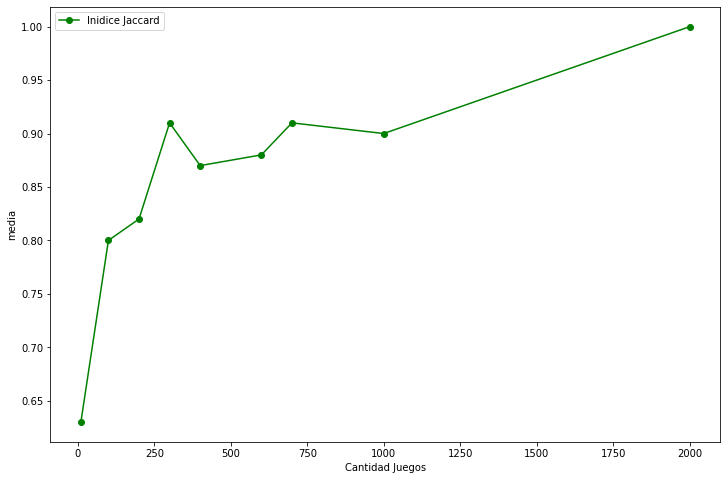

In [247]:
valores=[10,100,200,300,400,600,700,1000,2000]
res=[]
val=[]
for valor in valores:
    res.append(recomienda(2,valor,2))
    val.append(valor)
plt.figure(figsize=(12,8))
plt.plot(val, res, 'o-', color="g",label="Inidice Jaccard")
plt.legend()
plt.ylabel('media')
plt.xlabel('Cantidad Juegos')
plt.show() 
  

## Conclusión

+ <font size="3">En base a lo hecho hemos podido validar la hipótesis. Pudimos generar un sistema de recomendación en base a la utilización del coeficiente de Jaccard, el cual podríamos utilizar para el caso de los usuarios que jugaron pocas veces y así suplir las falencias del modelo utilizado en el trabajo número III.

+ <font size="3">Lo ideal sería poder evaluar siempre contra toda la base de datos de juegos. Pero hacerlo sería imposible por la cantidad de juegos que tiene el dataset de juegos. Por lo que se ve en la gráfica anterior con una muestra mayor a 1500 juegos la recomendación que se genera es bastante positiva proponiedo juegos con un índice de Jaccard bastante cercano a los juegos que ya jugó el jugador.

+ <font size="3">Respecto de la eficacia de la predicción, como no hemos utilizado un modelo que cuente con un factor de predicción como el RMSE por ejemplo, dado que hemos construido un algoritmo en torno al índice de Jaccard, hemos creado de algún modo una especie de scoring del método en función de la media de las diez mejores recomendaciones. Esa media refleja la distancia que hay entre los juegos que ha jugado el jugador y el resutltasdo predicho; y creemos que podriamos utilizarla como métrica de eficiencia.

<font size="3">***Mejoras al modelo***

<font size="3">Se podría mejorar el modelo haciendo el encoding de otras columnas interesantes del dataset de juegos como  ***genres*** la cual identifica el género o bien trabajando sobre los comentarios ingresados por el usuario en el dataset ***data_reviews*** sobre el cual podríamos  hacer una valoración de cuánto le gustó el juego al jugador mediante técnicas de procesamiento de lenguaje natural. Todo esto es posible y sin duda mejoraría la predicción pero también incrementaría la complejidad del modelo haciendo crecer a nuestro dataset en columnas categóricas. 